In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
import numpy as np
import lightkurve as lk
import threemultis
import matplotlib.pyplot as plt

/Users/nksaunde/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tpf = lk.search_targetpixelfile('K2-43').download()
tpf = tpf[10:]
tpf = tpf[np.in1d(tpf.time, tpf.to_lightcurve(aperture_mask='all').remove_nans().time)]
tpf = tpf[tpf.to_lightcurve().normalize().flux > 0.8]


mask = threemultis.utils.planet_mask(tpf.time, 'K2-43')
aper = tpf.create_threshold_mask(3)

In [4]:
# First pass, remove some very bad outliers
bad = np.zeros(len(tpf.time), bool)
for count in range(2):
    pld_lc = tpf[~bad].to_corrector('pld').correct(aperture_mask=aper, cadence_mask=mask[~bad])
    pld_lc = pld_lc.flatten(31, mask=~mask[~bad])
    bad |= np.in1d(tpf.time, pld_lc.time[np.abs(pld_lc.flux - 1) > 5 * np.std(pld_lc.flux - 1)])
    
tpf = tpf[~bad]
mask = mask[~bad]

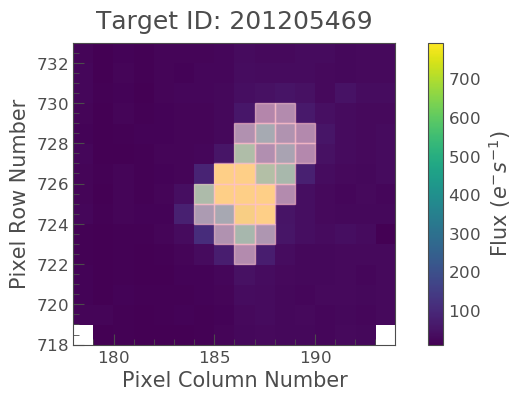

In [5]:
tpf.plot(aperture_mask=aper)

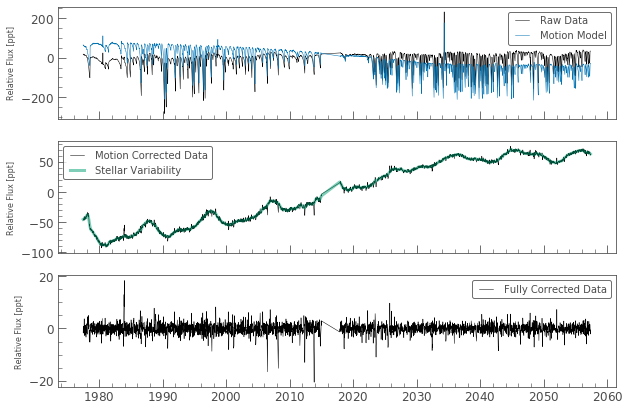

In [6]:
clc = threemultis.fit.PLD(tpf, planet_mask=mask, trim=2, aperture=aper, return_quick_corrected=True)

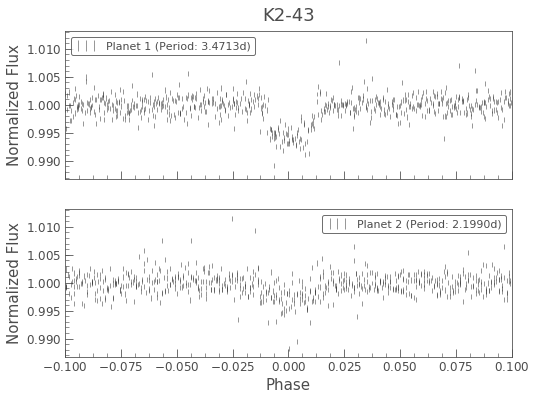

In [7]:
threemultis.utils.planet_plot(clc, 'K2-43');